# Introduction

The following notebook will explore the taxi dataset provided by the _NYC Taxi and Limousine Commission (TLC)_. The main conrens of this motebook will be as follows:
* Explore the acessability and copyrights of the provided data
* Describe the methodology of data collection
* Check the data for structural and non-structurl missingness, removing observations with missing vlaues
    * This includes also dropping variables with large percentage of missingness
* Check the validity of entries (range is within resonable boundries inferred from domain knowledge)
* Remove redundancy

# Data collection and copyrights

Following the [information](https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf) given by the TLC, we can clearly see that the "Yellow Taxi Cab" data from May 2015 is provided under the *Open Aceess* license. Thuse, we may freely explore and manipulate the data for educational purposes.

As for data collection, we note that most of the varialbes were recorded aoutmatically by the measurment aparatuses in the taxi as well as the driver themself. This information is conformed and exracte from the following link [1](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) [2](https://datasciencebocconi.github.io/Courses/Foundations/web/taxi_homework.html).

# Structural and non-structural missingness

## Auxiliary function and imports

Here we define some useful utility functions which will be used throughout the report.

In [34]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def preview_dataset(df):
    print(df.head())
    print(df.info())
    print(df.describe())
    print(df.columns)

def load_dataset(file):
    return pd.read_csv(file)

df = load_dataset('data/taxi_tidy_org.csv')


## Assessing missingness

### Non-structural missingness


Missing values for each column in percentage:
 Unnamed: 0           0.0
pickup_hour          0.0
pickup_month         0.0
pickup_week          0.0
pickup_doy           0.0
pickup_wday          0.0
length_time          0.0
pickup_BoroCode      0.0
pickup_NTACode       0.0
dropoff_BoroCode     0.0
dropoff_NTACode      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
vendor_id            0.0
passenger_count      0.0
trip_distance        0.0
fare_amount          0.0
pair                 0.0
dtype: float64


q:\Software\Miniconda3\envs\uni_testing\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
q:\Software\Miniconda3\envs\uni_testing\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


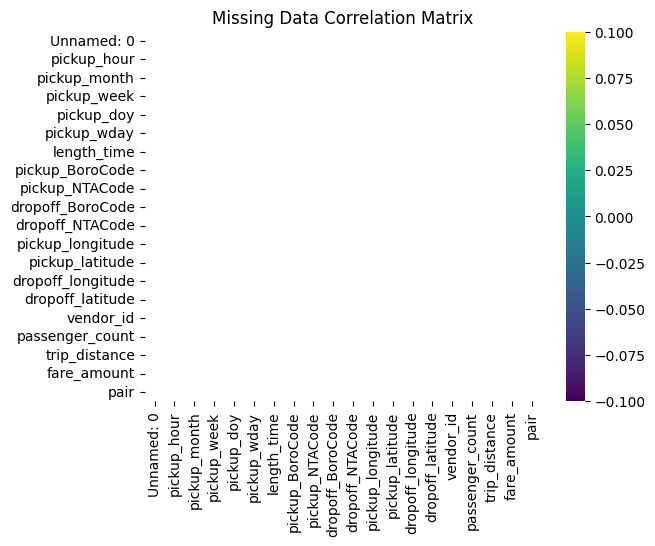

In [35]:
import pandas as pd
import missingno as msno

# Missing Data Analysis
# Checking the percentage of missing values in each column
missing_data = df.isnull().mean() * 100
print("\nMissing values for each column in percentage:\n", missing_data)

# Missing Data Correlation Analysis
# We will create a nullity matrix where missing data points are denoted with 1 and non-null data points are denoted with 0. 
# This allows us to calculate how the presence of missing data in one column is related to others.

# Create nullity matrix
nullity = df.isnull()

# Create correlation heatmap for missing data
sns.heatmap(nullity.corr(), annot=True, cmap='viridis')

plt.title('Missing Data Correlation Matrix')
plt.show()

It appears that the data is in tact, at least from the non-structural point of view.

### Structural missingness


We continue to examine whether each observation follows domain specific expectation we have for it. For example, the _pair_ column is expected to be a string equal to the concatenated result of _pickup_NTACode_ and _dropoff_NTACode_. We begin with a preview of the data.

In [36]:
print("The 'pair' column is the concatenation of the 'pickup_NTACode' and the 'dropoff_NTACode':",
 df['pair'].equals(df['pickup_NTACode'] + "-" + df['dropoff_NTACode']))

if df['pair'].equals(df['pickup_NTACode'] + "-" + df['dropoff_NTACode']):
    print("pickup_NTACode and dropoff_NTACode are redundant")
    df.drop(columns=['pickup_NTACode', 'dropoff_NTACode'], inplace=True)

print("The 'pickup_doy' is between May 1st and May 31st:", df['pickup_doy'].between(121, 152).all())

The 'pair' column is the concatenation of the 'pickup_NTACode' and the 'dropoff_NTACode': True
pickup_NTACode and dropoff_NTACode are redundant
The 'pickup_doy' is between May 1st and May 31st: True


## Reducing redundancy

Given that we saw the _pickup_NTACode_ and _dropoff_NTACode_ are redundant, we drop them. Additionally, we will convert the pickup and dropoff times to a format more appropriate for modelling purposes

In [37]:
# Convert the pickup_hour: Hour of the pick-up
# pickup_month: Month of the pick-up (always May)
# pickup_week: Week of the pick-up
# pickup_doy: Day of the year of the pick-up (from 1 to 365)
# pickup_wday: Day of the week of the pick-up (from 1 to 7)
# to absolute epoch timestamps

def combine_datetime(row):
    return pd.Timestamp(year=2015, 
                        month=row['pickup_month'], 
                        day=row['pickup_doy'] - 121, 
                        hour=row['pickup_hour'])

# We apply this function to each row of the DataFrame
df['pickup_time'] = df.apply(combine_datetime, axis=1)

# We then convert the datetime from being expressed in local time to being expressed 
# as a Unix timestamp (the number of seconds since 1970-01-01 00:00:00 UTC)
df['pickup_time'] = (df['pickup_time'] - pd.Timestamp("1970-01-01 00:00:00")) // pd.Timedelta('1s')

In [38]:
df.drop(columns=['pickup_month', 'pickup_week', 'pickup_doy', 'pickup_wday', 'pickup_hour'], inplace=True)

print(df.sample(5))

        Unnamed: 0  length_time  pickup_BoroCode  dropoff_BoroCode  \
160014      160015          391                3                 3   
383058      383059         2115                1                 4   
489532      489533          382                1                 1   
470611      470612          644                1                 1   
403986      403987         1208                1                 1   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
160014        -73.940819        40.712040         -73.930641   
383058        -73.986954        40.741280         -73.865334   
489532        -73.978111        40.745636         -73.955742   
470611        -73.999260        40.724735         -74.005798   
403986        -73.979332        40.749599         -74.008347   

        dropoff_latitude  vendor_id  passenger_count  trip_distance  \
160014         40.696171          2                1           1.31   
383058         40.770790          2                1

## Graphical exploration

Now that we have assessed that no values are missing and that the variables are withing reasonable range, we will explore the dataset visuallize with box-lots and historgrams.

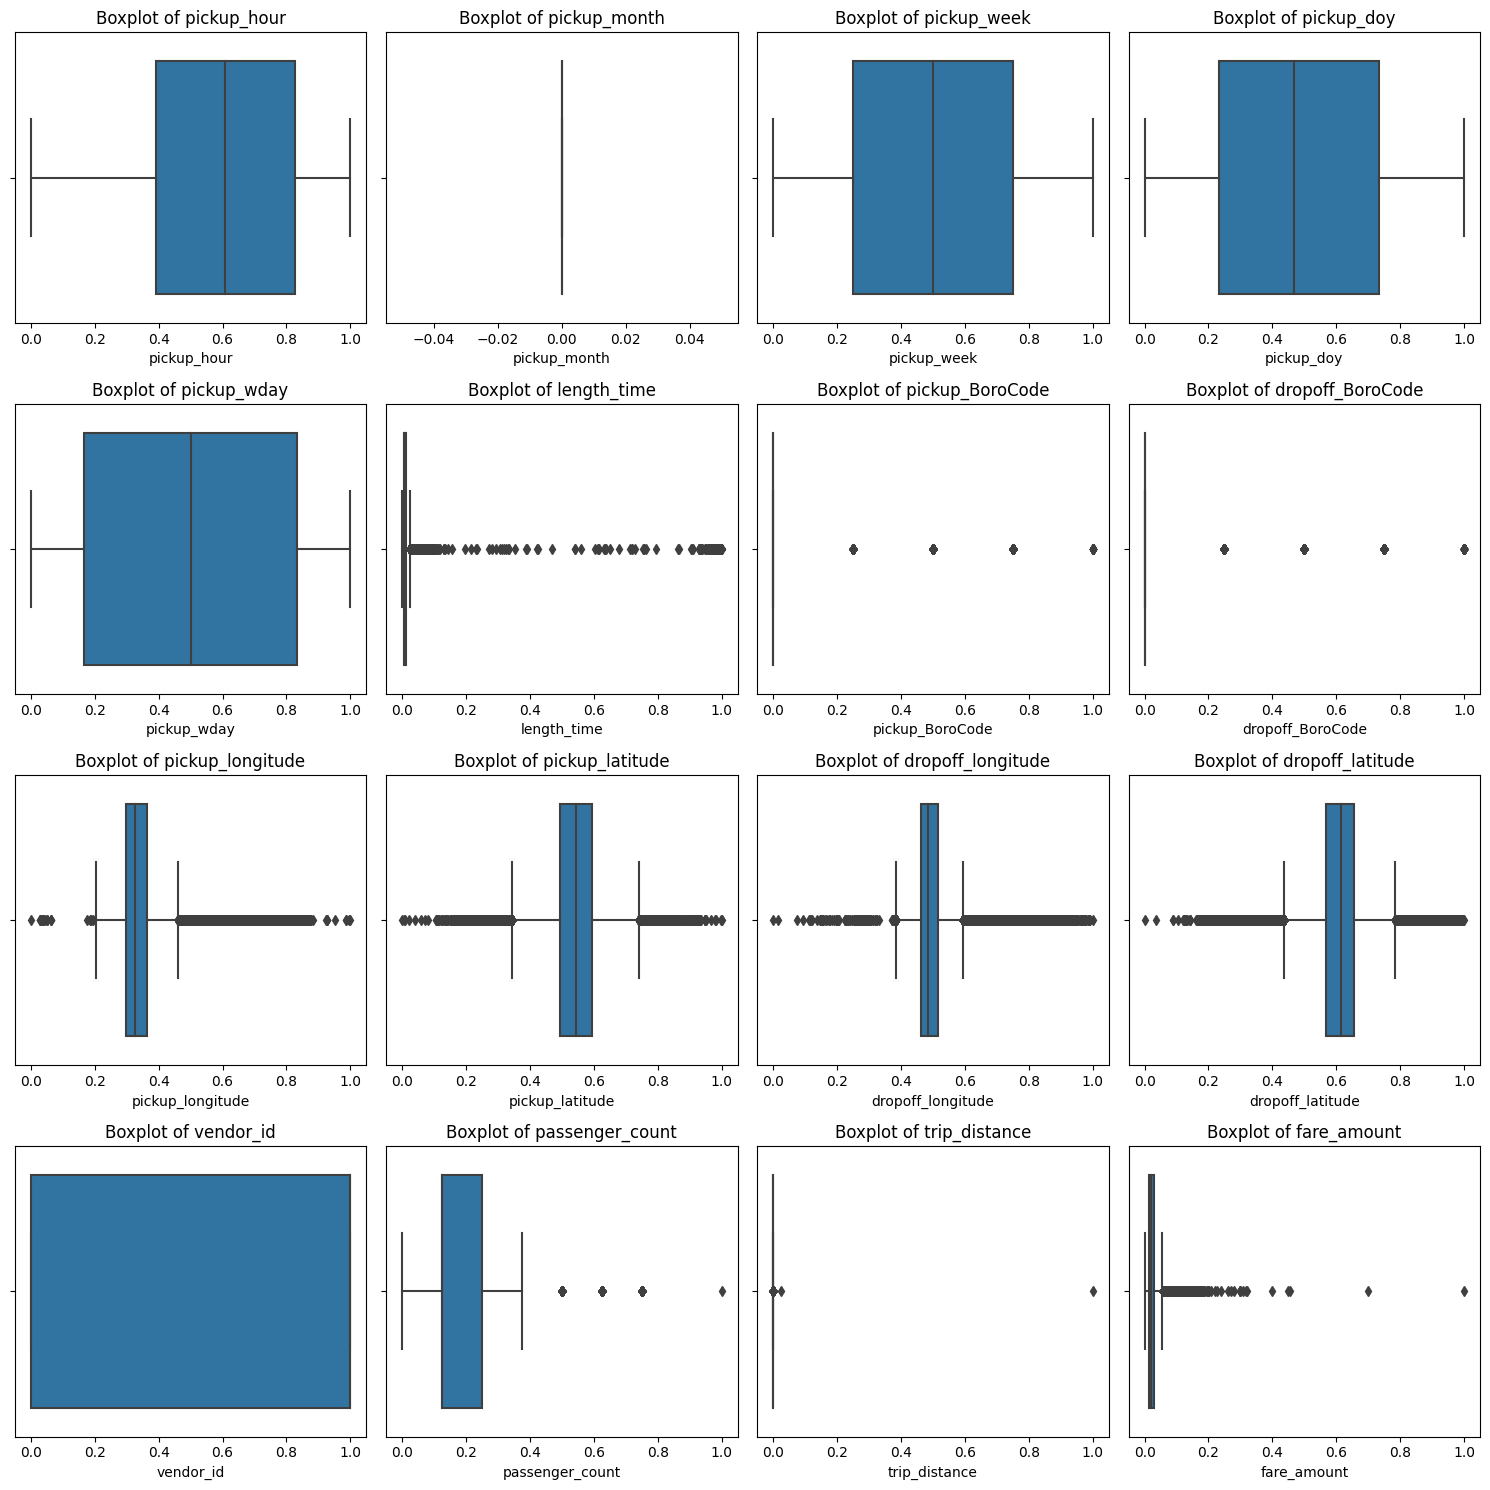

In [ ]:
# Normalize the numerical features to get meaningful plots
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

# Define number of rows and columns for subplot grid - aiming for a roughly square grid
num_vars = len(numerical_cols)
num_cols = int(num_vars**0.5)
num_rows = num_vars // num_cols + (num_vars % num_cols > 0)

# Create subplots of boxplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for ax, col in zip(axs.flat, numerical_cols):
    sns.boxplot(x=df_normalized[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Delete remaining empty subplots when the number of variable is not a perfect square
for ax in axs.flat[len(numerical_cols):]:
    fig.delaxes(ax)
    
plt.tight_layout()
plt.show()

# As for the categorical features, let's see the frequency of each category (bar plots)
for col in categorical_cols:
    if df[col].nunique() < 30:  # Only plot for columns with less unique entries
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Count plot of {col}')
        plt.show()

MemoryError: Unable to allocate 1.53 GiB for an array with shape (205843324,) and data type float64

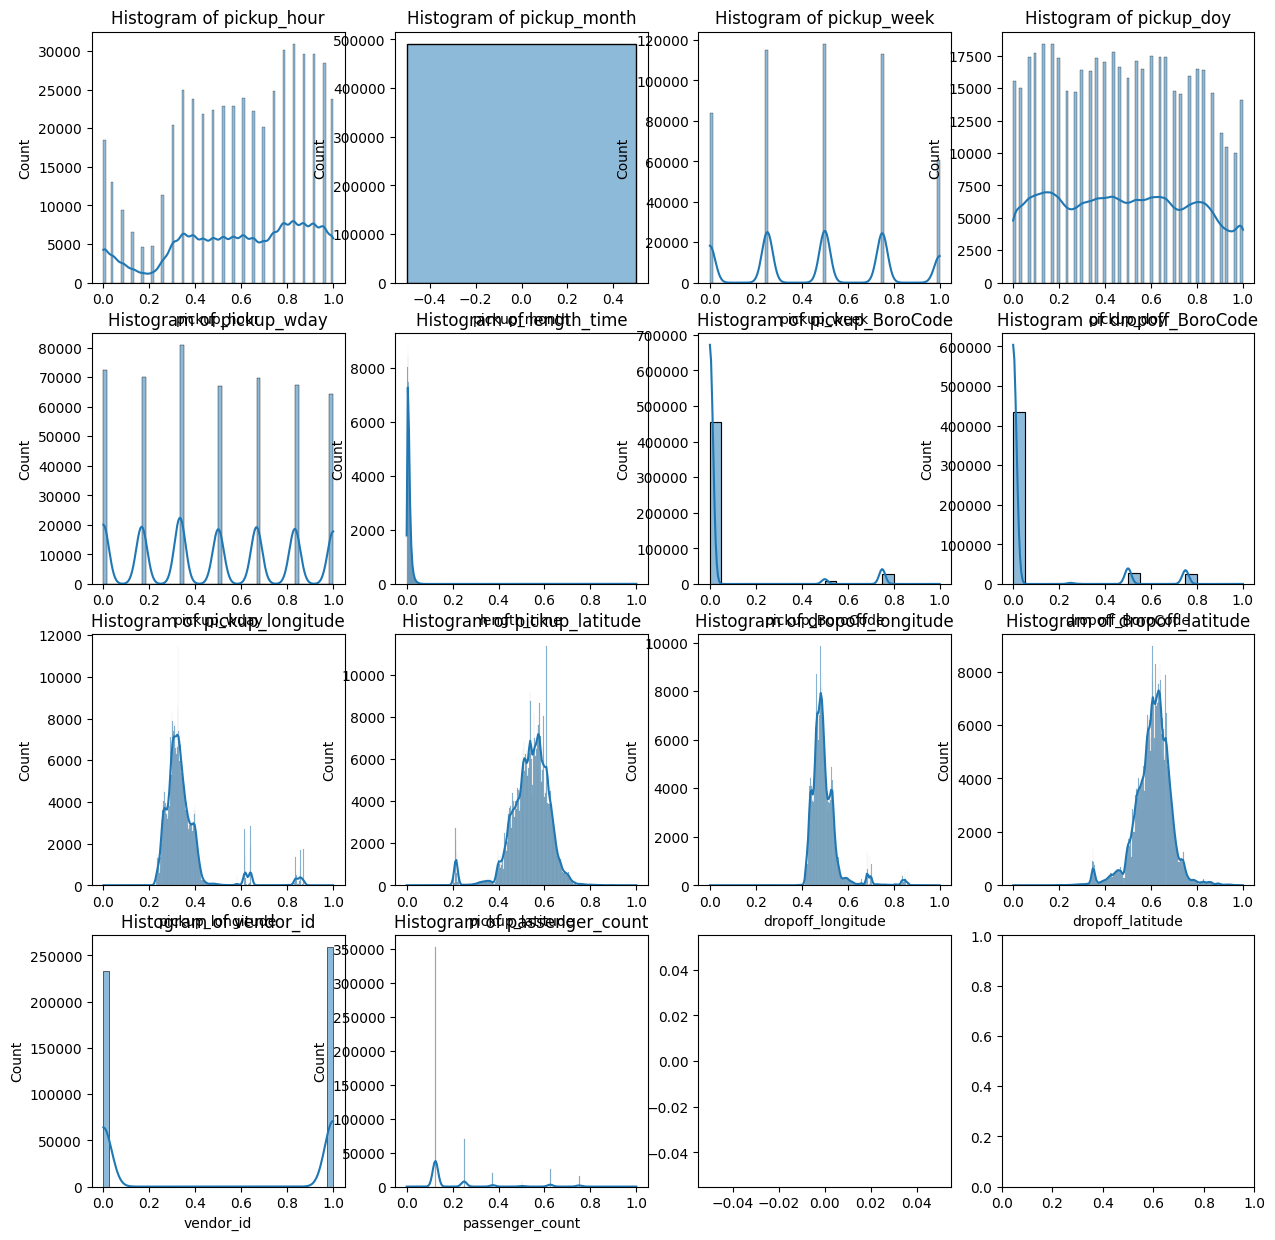

In [ ]:
# Histogram for each numerical column to visualize distribution
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for ax, col in zip(axs.flat, numerical_cols):
    sns.histplot(data=df_normalized, x=col, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Removing the remaining empty subplots when the number of variables is not a perfect square
for ax in axs.flat[len(numerical_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# For categorical features, count plots will remain the same
for col in categorical_cols:
    if df[col].nunique() < 30:  # Only plot for columns with less unique entries
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col)
        plt.title(f'Count plot of {col}')
        plt.show()